In [1]:
import numpy as np
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats



Using TensorFlow backend.


In [2]:
start = time.time()
df=pd.read_pickle("D:\Jupyter Notebook\input/WM811K.pkl")
end = time.time()
print(end-start,'초')
df.info()

45.88908815383911 초
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [6]:
training_size_list = [i/10 for i in range(1,11)]

In [7]:
df = df.drop(['waferIndex','trianTestLabel','lotName'], axis = 1)
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

df['failureNum']=df.failureType
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureNum':mapping_type})
idx = df[df['dieSize']<100.0].index.tolist()
df = df.drop(idx)
df.reset_index()
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel = df_withlabel.reset_index()

c:\users\user\anaconda3\envs\tf2.0\lib\site-packages\pandas\core\internals\managers.py:1937: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [8]:
start = time.time()
label = list()
for i in range(len(df_withlabel)):
    # skip null label
    if len(df_withlabel.iloc[i,:]['failureType']) == 0:
        continue
    label.append(df_withlabel.iloc[i,:]['failureType'][0][0])

y = np.array(label).reshape((-1,1))
end = time.time(); print(end - start)
df_withlabel.failureNum.value_counts()
for i in range(len(df_withlabel)):
  df_withlabel['failureType'][i] = df_withlabel['failureType'][i][0][0]
y = np.array(df_withlabel['failureType'])
y = y.reshape(-1,1)
end = time.time(); print(end - start)

44.45586919784546


c:\users\user\anaconda3\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


185.49998092651367


In [9]:
from keras.callbacks import EarlyStopping
es = EarlyStopping( monitor='val_loss',patience=10,mode='auto')
epoch = 100

# wafer resize

In [8]:
def waferResize(WaferMapList):
  start = time.time()
  X = WaferMapList
  X_binary = [np.where(x<=1,0,1) for x in X]
  X_resize=[resize(x,(32,32), preserve_range=True, anti_aliasing=False) for x in X_binary]
  X_resize = np.array(X_resize)
  end = time.time(); print('소요시간:', end-start)
  return X_resize

In [9]:
withLabel_resize = waferResize(df_withlabel.waferMap)
X = withLabel_resize
X = X.reshape(-1,32,32,1)

소요시간: 72.33731031417847


In [10]:
faulty_case = np.unique(y)
for i, l in enumerate(faulty_case):
    y[y==l] = i
# one-hot-encoding
y_onehot = to_categorical(y)
x_trainval, x_test, y_trainval, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=2019,stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=2019)

In [11]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# model 1 default

In [12]:
def create_model():
    input_shape = (32, 32, 1)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(conv_3)
    
    flat = layers.Flatten()(pool_1)

    dense_1 = layers.Dense(256, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model
batch_size =128

In [13]:
start = time.time()
model_1 = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, verbose=2)
history = model_1.fit(x_train, y_train,
         validation_data=[x_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
model_1.model.summary()

Train on 103767 samples, validate on 34589 samples
Epoch 1/100
 - 20s - loss: 0.2139 - accuracy: 0.9428 - val_loss: 0.1566 - val_accuracy: 0.9510
Epoch 2/100
 - 16s - loss: 0.0978 - accuracy: 0.9695 - val_loss: 0.1010 - val_accuracy: 0.9684
Epoch 3/100
 - 16s - loss: 0.0636 - accuracy: 0.9785 - val_loss: 0.0989 - val_accuracy: 0.9702
Epoch 4/100
 - 16s - loss: 0.0362 - accuracy: 0.9876 - val_loss: 0.1423 - val_accuracy: 0.9690
Epoch 5/100
 - 16s - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.1390 - val_accuracy: 0.9690
Epoch 6/100
 - 16s - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.1707 - val_accuracy: 0.9690
Epoch 7/100
 - 16s - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.1593 - val_accuracy: 0.9693
Epoch 8/100
 - 16s - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.2116 - val_accuracy: 0.9658
Epoch 9/100
 - 16s - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.2721 - val_accuracy: 0.9685
Epoch 10/100
 - 16s - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.2055 - val_accuracy: 0.968

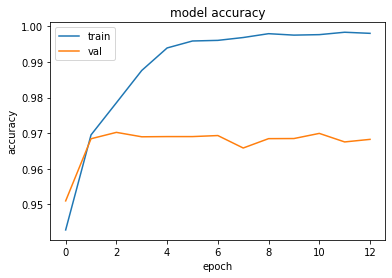

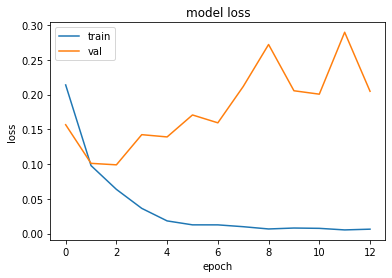

In [17]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
y_hat=model_1.predict(x_test)
enc = OneHotEncoder(handle_unknown='ignore')
y_hat=y_hat.reshape(-1,1)
enc.fit(y_hat)
y_true=enc.inverse_transform(y_test)
y_train_true =enc.inverse_transform(y_train)

Confusion matrix, without normalization
Normalized confusion matrix


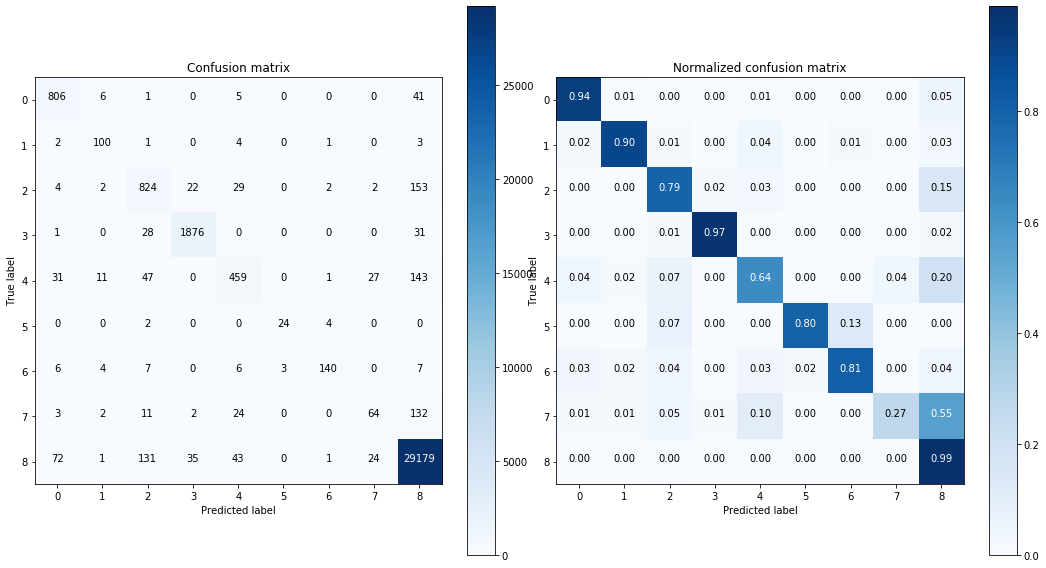

Train Accuracy: 0.9980629679956056
F1 Macro: 0.8084279972887332
F1 Micro: 0.9676785198034114
********** time: 392.3177316188812 **********


In [19]:
y_hat=model_1.predict(x_test)
y_hat=y_hat.reshape(-1,1)
y_train_hat = model_1.predict(x_train)
y_train_hat = y_train_hat.reshape(-1,1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_hat)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

print("Train Accuracy:",accuracy_score(y_train_true,y_train_hat))
print("F1 Macro:", f1_score(y_true, y_hat, average='macro'))
print("F1 Micro:", f1_score(y_true, y_hat, average='micro'))

print("*"*10,'time:',time.time()-start,'*'*10)

In [21]:
# Model 2 Dropout

def create_model():
    input_shape = (32,32,1)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    pool_1 = layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_2)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool_1)
    
    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(256, activation='relu')(flat)
    drop_1 = layers.Dropout(0.3)(dense_1)
    dense_2 = layers.Dense(128, activation='relu')(drop_1)
    drop_2 = layers.Dropout(0.3)(dense_2)
    output_tensor = layers.Dense(9, activation='softmax')(drop_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model
start = time.time()
model_2 = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, verbose=2)
history = model_2.fit(x_train, y_train,
         validation_data=[x_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
model_2.model.summary()

Train on 103767 samples, validate on 34589 samples
Epoch 1/100
 - 12s - loss: 0.2391 - accuracy: 0.9386 - val_loss: 0.1243 - val_accuracy: 0.9644
Epoch 2/100
 - 12s - loss: 0.1215 - accuracy: 0.9638 - val_loss: 0.1018 - val_accuracy: 0.9683
Epoch 3/100
 - 12s - loss: 0.0896 - accuracy: 0.9714 - val_loss: 0.0948 - val_accuracy: 0.9706
Epoch 4/100
 - 11s - loss: 0.0669 - accuracy: 0.9776 - val_loss: 0.1144 - val_accuracy: 0.9694
Epoch 5/100
 - 11s - loss: 0.0477 - accuracy: 0.9841 - val_loss: 0.1175 - val_accuracy: 0.9708
Epoch 6/100
 - 11s - loss: 0.0346 - accuracy: 0.9883 - val_loss: 0.1287 - val_accuracy: 0.9689
Epoch 7/100
 - 11s - loss: 0.0256 - accuracy: 0.9912 - val_loss: 0.1527 - val_accuracy: 0.9696
Epoch 8/100
 - 11s - loss: 0.0219 - accuracy: 0.9929 - val_loss: 0.1626 - val_accuracy: 0.9714
Epoch 9/100
 - 11s - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.1972 - val_accuracy: 0.9704
Epoch 10/100
 - 11s - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.2139 - val_accuracy: 0.969

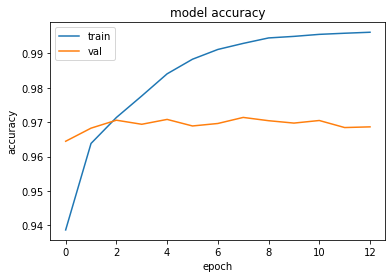

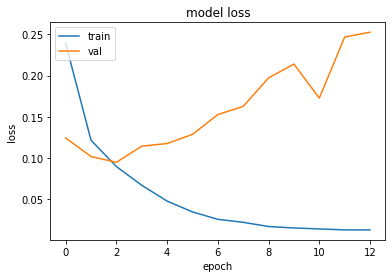

Confusion matrix, without normalization
Normalized confusion matrix


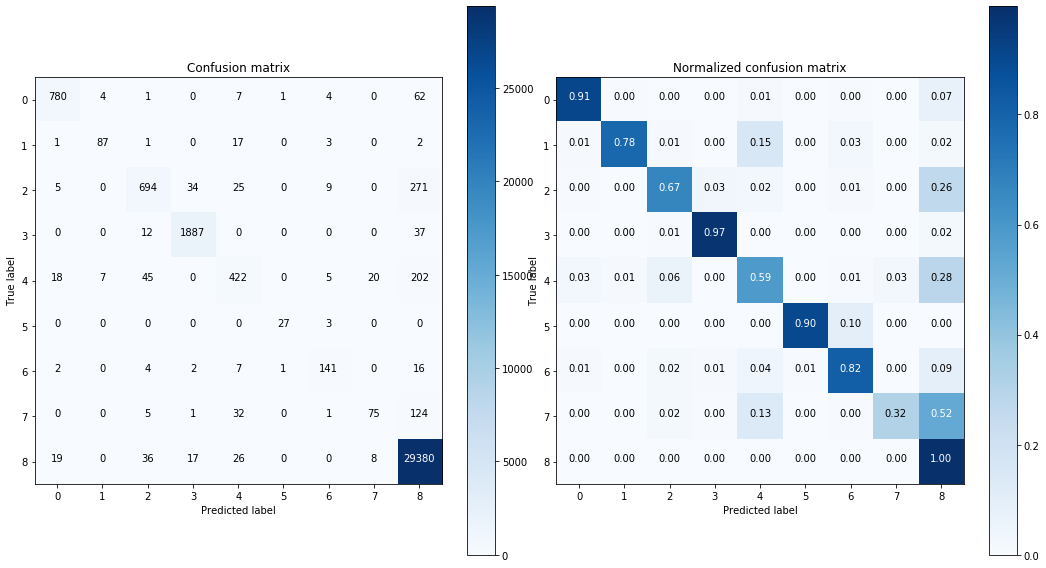

Train Accuracy: 0.9987664671812811
F1 Macro: 0.8148964808725396
F1 Micro: 0.9682856316854582
********** time: 151.08365058898926 **********


In [22]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

y_hat=model_2.predict(x_test)
y_hat=y_hat.reshape(-1,1)
y_train_hat = model_2.predict(x_train)
y_train_hat = y_train_hat.reshape(-1,1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_hat)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

print("Train Accuracy:",accuracy_score(y_train_true,y_train_hat))
print("F1 Macro:", f1_score(y_true, y_hat, average='macro'))
print("F1 Micro:", f1_score(y_true, y_hat, average='micro'))
print("*"*10,'time:',time.time()-start,'*'*10)

# Feature Extraction

In [ ]:
# illustration of 13 regions
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [7]:
start = time.time()
df_withlabel['fea_reg']=df_withlabel.waferMap.apply(find_regions)
print(time.time()-start)

27.09053897857666


In [8]:
def change_val(img):
    img[img==1] =0  
    return img

df_withlabel_copy = df_withlabel.copy()
df_withlabel_copy['new_waferMap'] =df_withlabel_copy.waferMap.apply(change_val)

def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew 

In [9]:
start = time.time()
df_withlabel_copy['fea_cub_mean'] =df_withlabel_copy.waferMap.apply(cubic_inter_mean)
df_withlabel_copy['fea_cub_std'] =df_withlabel_copy.waferMap.apply(cubic_inter_std)
end = time.time(); print(end-start); print((end-start)/60,'min')

C:\Users\kelll\Anaconda3\envs\venv1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kelll\Anaconda3\envs\venv1\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\kelll\Anaconda3\envs\venv1\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range p

1704.158946275711
28.402649104595184 min


In [10]:
df_all=df_withlabel_copy.copy()

a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c)),axis=1) #53 in total

label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

In [11]:

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({8: 110474, 3: 7325, 2: 3896, 0: 3208, 4: 2696, 6: 900, 5: 666, 1: 432, 7: 112})
Testing target statistics: Counter({8: 36953, 3: 2355, 2: 1293, 0: 1086, 4: 897, 6: 293, 5: 200, 1: 123, 7: 37})


In [12]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
start = time.time()
pipe = Pipeline([('preprocessing', None),('classifier', SVC())])
hyperparam_grid = [
                   {'classifier': [LogisticRegression()], 'preprocessing': [None],
                    'classifier__C': [0.001,0.01,0.1,1,10,100,1000]},              
]
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

grid = GridSearchCV(pipe, hyperparam_grid, scoring='accuracy',refit=True, cv=kfold, verbose=10)
grid.fit(X_train, y_train)

print('Best params:\n{}\n'.format(grid.best_params_))
print("Best cross-validation score: {:.2f}" .format(grid.best_score_))
print("Test Score: {:.2f}" .format(grid.score(X_test,y_test)))

y_test_pred = grid.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')
plt.show()

with open('grid search result wafermap.txt', 'a') as f:
    f.write('\n\n\n'+'*' *10+'*' *10+'\n')
    f.write('Best param:\n'+str(grid.best_params_)+'\n\n')
    f.write('Best cross-val score:'+ str(grid.best_score_)+'\n')
    f.write('Test score:          '+ str(grid.score(X_test, y_test))+'\n')
    f.write('Time:                '+ str((time.time()-start)/60)+'min')

print("F1 Macro:", f1_score(y_test, y_test_pred, average='macro'))
print("F1 Micro:", f1_score(y_test, y_test_pred, average='micro'))

end = time.time(); print(end - start, (end-start)/60,'min')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] classifier=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), classifier__C=1, classifier__gamma=0.0001, preprocessing=None 
[CV]  classifier=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), classifier__C=1, classifier__gamma=0.0001, preprocessing=None, score=0.929, total= 4.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
[CV] classifier=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', de

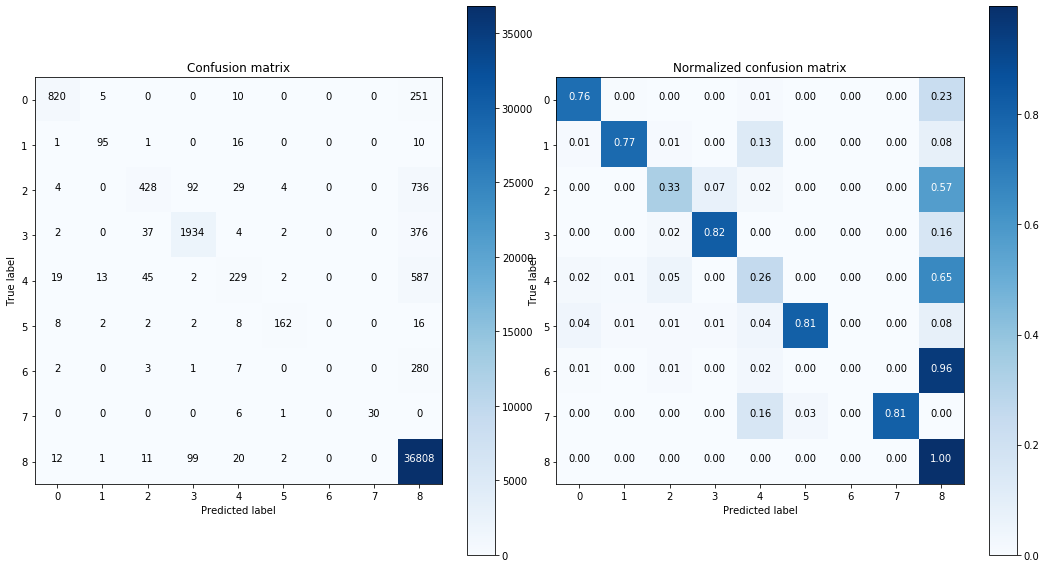

F1 Macro: 0.6747984127095817
F1 Micro: 0.9368365057705206
3102.5329070091248 51.70888178348541 min


C:\Users\kelll\Anaconda3\envs\venv1\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
start = time.time()
pipe = Pipeline([('preprocessing', None),('classifier', SVC())])
hyperparam_grid = [
                   {'classifier': [SVC()], 'preprocessing': [None],
                    'classifier__C': [1],
                    'classifier__gamma': [0.0001,0.001]}
                   
]
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

grid = GridSearchCV(pipe, hyperparam_grid, scoring='accuracy',refit=True, cv=kfold,verbose=100)
grid.fit(X_train, y_train)

print('Best params:\n{}\n'.format(grid.best_params_))
print("Best cross-validation score: {:.2f}" .format(grid.best_score_))
print("Test Score: {:.2f}" .format(grid.score(X_test,y_test)))

y_test_pred = grid.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

with open('grid search result wafermap.txt', 'a') as f:
    f.write('\n\n\n'+'*' *10+'*' *10+'\n')
    f.write('Best param:\n'+str(grid.best_params_)+'\n\n')
    f.write('Best cross-val score:'+ str(grid.best_score_)+'\n')
    f.write('Test score:          '+ str(grid.score(X_test, y_test))+'\n')
    f.write('Time:                '+ str((time.time()-start)/60)+'min')

print("F1 Macro:", f1_score(y_test, y_test_pred, average='macro'))
print("F1 Micro:", f1_score(y_test, y_test_pred, average='micro'))

end = time.time(); print(end - start, (end-start)/60,'min')

In [ ]:
# ---RandomForestClassifier ---# 
# One-Vs-One
start = time.time()
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,random_state = RANDOM_STATE).fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print("F1 Macro:", f1_score(y_test, y_test_pred, average='macro'))
print("F1 Micro:", f1_score(y_test, y_test_pred, average='micro'))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

with open('grid search result wafermap.txt', 'a') as f:
    f.write('\n\n\n'+'*' *10+file+'*' *10+'\n')
    f.write('Best param:\n'+str(grid.best_params_)+'\n\n')
    f.write('Best cross-val score:'+ str(grid.best_score_)+'\n')
    f.write('Test score:          '+ str(grid.score(X_test, y_test))+'\n')
    f.write('Time:                '+ str((time.time()-start)/60)+'min')

end = time.time(); print(end - start, (end-start)/60,'min')